In [2]:
import yfinance as yf

import pandas as pd
import numpy as np

import statsmodels.api as sm
from scipy.stats import norm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import featEngine as fe

import datetime

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:


# Manual Calculation for Beta

def get_beta_pvals(betas,X,Y):
    #betas.index = X.columns
    betas = pd.DataFrame(betas,index = X.columns,columns = Y.columns)
    #print(betas)
    preds = X@betas
    #print(preds)
    e = df - preds
    #print(e)
    n,p = X.shape#X@betas
    dof = n - p
    resid_var = ((e.T@e)/dof).values[0]
    #resid_var.values[0]

    #resid_var = resid_var[0][0]
    # Step 5: Standard errors of coefficients
    cov_matrix = resid_var * np.linalg.inv(X.T @ X)
    std_errors = np.sqrt(np.diag(cov_matrix))
    z_stats = betas.values.T/std_errors

    p_values = [2 * (1 - norm.cdf(abs(z))) for z in z_stats]
    return p_values


# Get Features

In [8]:
tkr = 'UEC'
fdmnt = pd.read_excel("Financial Data.xlsx",sheet_name = tkr)
fdmnt.set_index('Date',inplace = True)
fdmnt.index = [datetime.datetime.strptime(dt,"%Y-%m-%d") + datetime.timedelta(days = 48) for dt in fdmnt.index]
tkr_exch = 'UEC'
fdmnt.drop([tkr_exch,'Quarter','market_cap'],axis = 1,inplace = True)

## Get dependent variable

In [9]:
df = yf.download(tkr_exch)[['Close']]       ## Get Financial Data
fwd = 20*2
df = df.pct_change(fwd).shift(-fwd)

[*********************100%***********************]  1 of 1 completed


In [10]:


fcln = fe.featureClean(fdmnt,df)
df = fcln.custom_reindex(df,fdmnt)     ## Reindex with the financial data with the fundamental data
df = df.fillna(0)
df

,"(Close, UEC)"
2006-02-17,0.000000
2006-05-18,0.000000
2006-08-17,0.000000
2006-11-17,0.000000
2007-02-17,0.000000
...,...
2024-03-19,0.092332
2024-06-17,-0.219472
2024-09-17,0.542169
2024-12-18,-0.163408


In [11]:
lvls = fdmnt.columns
chg = fdmnt.columns
X = fcln.generate_features(chg,lvls)
X = fcln.clean_features(X)
X

,eps_lvl,cf_net_inc_lvl,ebitda_lvl,cash_flow_per_sh_lvl,ebitda_per_sh_lvl,cash_flow_to_net_inc_lvl,bs_sh_out_lvl,cf_net_inc.1_lvl,cf_depr_amort_lvl,cf_non_cash_items_detailed_lvl,...,bs_add_paid_in_cap_chg,bs_pure_retained_earnings_chg,bs_eqty_bef_minority_int_detailed_chg,bs_total_equity_chg,bs_tot_liab_and_eqy_chg,bs_sh_out.1_chg,net_debt_chg,net_debt_to_shrhldr_eqty_chg,tce_ratio_chg,cur_ratio_chg
2006-02-17,0.532628,1.444665,1.643065,1.231608,0.598642,-0.189282,-0.996584,1.444665,0.000000,-0.195305,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-05-18,0.310308,1.333608,1.514405,0.975524,0.295962,-0.162417,-1.058142,1.333608,0.000000,-0.112249,...,-0.391254,0.706564,-0.329786,-0.329786,-0.299634,-1.185600,0.034724,1.774491,4.711889,0.014524
2006-08-17,-0.992556,0.775421,0.866544,0.261423,-1.170544,-0.161824,-1.049820,0.775421,0.000000,0.471106,...,-0.205913,-0.353092,-0.217013,-0.217013,-0.207988,-0.407893,-0.133673,-6.717061,6.997960,3.498135
2006-11-17,-1.567203,0.497848,0.486170,-0.883858,-1.817036,-0.121179,-1.039721,0.497848,-1.127937,0.426417,...,-0.445528,0.411314,-0.365352,-0.365352,-0.325421,-0.388116,0.104392,0.589903,-0.243331,-1.536124
2007-02-17,-2.277750,0.206905,0.144943,-1.548646,-2.600339,-0.118629,-0.985454,0.206905,-1.119450,0.603896,...,-0.043688,-0.031832,-0.019840,-0.019840,-0.039793,0.103427,-0.443304,-0.426638,-0.057244,1.674290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,1.155418,1.139709,-0.364759,0.085050,0.932427,2.608723,2.184254,1.139709,0.766524,-2.097033,...,1.687543,1.447453,2.175674,2.175674,1.575170,0.598371,-1.335470,-0.084705,-0.072007,0.476184
2024-06-17,1.041340,0.358789,-1.441711,0.060548,0.789973,0.827460,2.226663,0.358789,0.808733,-2.186780,...,0.537340,-3.207861,-0.059301,-0.059301,-0.314177,-0.028538,-0.197977,0.005806,-0.108367,0.557911
2024-09-17,0.833915,-1.041619,-3.821379,-0.835261,0.458670,0.573245,2.264846,-1.041619,0.865012,-3.003556,...,-0.021958,-2.239304,-0.348343,-0.348343,-0.031561,-0.075568,0.042792,0.024959,-0.203596,-0.420075
2024-12-18,0.539560,-3.145007,-4.037599,-0.055410,0.448618,0.068236,2.341016,-3.145007,0.940988,0.019208,...,1.444236,-3.309982,0.991459,0.991459,0.349518,0.347188,-4.371409,-0.364379,-0.059972,1.774942


In [12]:
fsel = fe.featureSelect(X,df)
features = fsel.feature_selection_mk1()
features

['cf_change_in_accounts_payable_lvl',
 'cf_other_investing_act_detailed_lvl',
 'cf_net_chng_cash_lvl',
 'is_other_operating_expenses_lvl',
 'is_nonop_income_loss_lvl',
 'net_debt_to_shrhldr_eqty_lvl',
 'cur_ratio_lvl',
 'cf_change_in_prepaid_assets_chg',
 'cf_proc_fr_repurch_eqty_detailed_chg',
 'cf_incr_cap_stock_chg',
 'cf_net_chng_cash_chg',
 'pr_to_free_cash_flow_chg',
 'is_operating_expn_chg',
 'is_other_operating_expenses_chg',
 'is_nonop_income_loss_chg',
 'is_other_nonop_income_loss_chg',
 'is_net_income_chg',
 'is_earn_for_common_chg',
 'dil_eps_cont_ops_chg',
 'bs_accum_depr_chg']

# Now Get all Relevant Information for All Tickers

In [16]:
tickers_map = pd.read_excel('tickers_map.xlsx')
filepath = "Financial Data.xlsx"
sheet_names = pd.ExcelFile(filepath).sheet_names

In [29]:
features_map = {}
for tkr in sheet_names:
    try:
        fdmnt = pd.read_excel("Financial Data.xlsx",sheet_name = tkr)
        tkr_exch = tickers_map[tickers_map['Name']==tkr]['Ticker'].values[0]
        fdmnt.set_index('Date',inplace = True)
        fdmnt.index = [datetime.datetime.strptime(dt,"%Y-%m-%d") + datetime.timedelta(days = 48) for dt in fdmnt.index]
        fdmnt.drop([tkr_exch,'Quarter','market_cap'],axis = 1,inplace = True)

        df = yf.download(tkr_exch)[['Close']]       ## Get Financial Data
        fwd = 20
        df = df.pct_change(fwd).shift(-fwd)

        fcln = fe.featureClean(fdmnt,df)
        df = fcln.custom_reindex(df,fdmnt)     ## Reindex with the financial data with the fundamental data
        df = df.fillna(0)

        lvls = fdmnt.columns
        chg = fdmnt.columns
        X = fcln.generate_features(chg,lvls)
        X = fcln.clean_features(X)

        fsel = fe.featureSelect(X,df)
        features = fsel.feature_selection_mk1()
        features_map[tkr] = pd.DataFrame(features,columns = ['Features'])
    except:
        print(tkr," failed")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CGN Mining  failed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Haidilao  failed


[*********************100%***********************]  1 of 1 completed


In [33]:
with pd.ExcelWriter("features_map.xlsx", engine="xlsxwriter") as writer:
    for sheet_name, dataframe in features_map.items():
        dataframe.to_excel(writer, sheet_name=sheet_name, index=False)

In [ ]:


X = fdmt[feats].fillna(0)
#X = (X-X.mean())/X.std()               # Standardaize
X = sm.add_constant(X)
model = sm.OLS(df,X).fit()

[*********************100%***********************]  1 of 1 completed


In [523]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ('Close', 'UEC')   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1.739
Date:                Sun, 13 Jul 2025   Prob (F-statistic):             0.0580
Time:                        16:45:11   Log-Likelihood:                 1.7902
No. Observations:                  77   AIC:                             34.42
Df Residuals:                      58   BIC:                             78.95
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         0.1245      0.074      1.673      0.100      -0.024       0.273
market_cap_lvl                            -2.005e-10   1.46e-10     -1.371      0.176   -4.93e-10    9.22e-11
cf_net_chng_cash_lvl                       5.003e-09   2.99e-09      1.671      0.100   -9.91e-10     1.1e-08
is_other_operating_expenses_lvl            -3.67e-09   8.24e-09     -0.446      0.658   -2.02e-08    1.28e-08
bs_acct_payable_and_accruals_detailed_lvl  2.316e-08   1.65e-08      1.407      0.165    -9.8e-09    5.61e-08
cur_ratio_lvl                                -0.0100      0.006     -1.639      0.107      -0.022       0.002
cf_net_inc_chg                             3.388e-09   6.03e-09      0.562      0.577   -8.69e-09    1.55e-08
cf_net_inc.1_chg                          -1.499e-08   1.23e-08     -1.224      0.226   -3.95e-08    9.53e-09
cf_proc_fr_repurch_eqty_detailed_chg      -1.181e-09   1.35e-09     -0.873      0.386   -3.89e-09    1.53e-09
cf_incr_cap_stock_chg                     -3.021e-09   1.29e-09     -2.341      0.023    -5.6e-09   -4.38e-10
cf_net_chng_cash_chg                      -2.444e-09   1.94e-09     -1.258      0.214   -6.33e-09    1.45e-09
pr_to_free_cash_flow_chg                     -0.0008      0.001     -1.223      0.226      -0.002       0.001
is_operating_expn_chg                      1.392e-08   1.93e-08      0.721      0.474   -2.47e-08    5.25e-08
is_other_operating_expenses_chg            2.376e-08    1.3e-08      1.834      0.072   -2.18e-09    4.97e-08
is_nonop_income_loss_chg                  -5.445e-08    1.7e-07     -0.321      0.750   -3.94e-07    2.85e-07
is_other_nonop_income_loss_chg             3.857e-08   1.69e-07      0.228      0.820   -2.99e-07    3.77e-07
dil_eps_cont_ops_chg                          1.5912      1.194      1.333      0.188      -0.799       3.981
bs_other_current_assets_detailed_chg      -6.206e-08   5.05e-08     -1.228      0.224   -1.63e-07    3.91e-08
bs_accum_depr_chg                         -1.447e-07   8.24e-08     -1.756      0.084    -3.1e-07    2.03e-08
net_debt_to_shrhldr_eqty_chg                 -0.0017      0.001     -1.169      0.247      -0.005       0.001
cur_ratio_chg                                -0.0037      0.007     -0.526      0.601      -0.018       0.010
==============================================================================
Omnibus:                       43.673   Durbin-Watson:                   2.422
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.420
Skew:                           1.815   Prob(JB):                     8.76e-31
Kurtosis:                       8.475   Cond. No.                     6.18e+17
================================================

# ElasticNet Attempt

In [524]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.1, l1_ratio=0, random_state=42,max_iter = 10000)
enet.fit(X,df)

lr = LinearRegression().fit(X,df)

c:\Users\kmavy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e+00, tolerance: 6.626e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [525]:
def get_summary_stats(betas,X,Y):
    pvals = get_beta_pvals(enet.coef_,X,Y)[0]
    df= pd.DataFrame(zip(betas,pvals))
    df.index = X.columns
    df.columns = ['betas','p-value']
    return df

In [526]:
get_summary_stats(enet.coef_,X,df)

C:\Users\kmavy\AppData\Local\Temp\ipykernel_15736\3694408516.py:71: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(np.diag(cov_matrix))


,betas,p-value
const,0.000000e+00,1.000000e+00
market_cap_lvl,-2.120647e-10,1.241661e-01
cf_net_chng_cash_lvl,6.013251e-09,8.700721e-02
is_other_operating_expenses_lvl,-2.324927e-09,7.869277e-01
bs_acct_payable_and_accruals_detailed_lvl,2.781302e-08,1.222483e-01
cur_ratio_lvl,-9.912458e-03,4.712514e-07
cf_net_inc_chg,-6.764978e-10,NaN
cf_net_inc.1_chg,-1.988712e-20,NaN
cf_proc_fr_repurch_eqty_detailed_chg,-4.402194e-09,NaN
cf_incr_cap_stock_chg,-1.317546e-20,NaN


<Axes: >

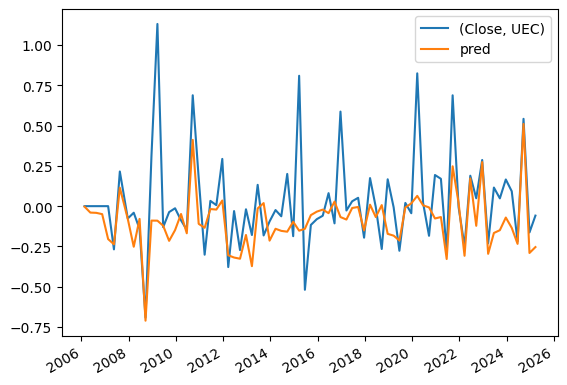

In [527]:
pred = enet.coef_.T@X.T
df['pred'] = pred
df.plot()

In [528]:
df.corr()

,"(Close, UEC)",pred
"(Close, UEC)",1.000000,0.575267
pred,0.575267,1.000000


## Feature Selection

In [487]:
fdmt

,pe_ratio_lvl,eps_lvl,revenue_per_sh_lvl,profit_margin_lvl,return_com_eqy_lvl,is_gross_profit_lvl,cf_net_inc_lvl,ebitda_lvl,cash_flow_per_sh_lvl,ebitda_per_sh_lvl,...,bs_total_equity_chg,bs_tot_liab_and_eqy_chg,bs_sh_out.1_chg,bs_total_capital_leases_chg,net_debt_chg,net_debt_to_shrhldr_eqty_chg,tce_ratio_chg,cur_ratio_chg,cash_conversion_cycle_chg,num_of_employees_chg
2006-02-17,NaN,-0.131960,0.000097,-1.354794e+05,NaN,-1460.0,-1467947,-1701953,-0.027804,-0.113544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-18,NaN,-0.174538,0.000060,-2.907074e+05,NaN,-1460.0,-2707612,-2942019,-0.057888,-0.166795,...,116087.0,16232.0,-7101169.0,NaN,4295.0,53.481464,120.208384,0.221201,NaN,NaN
2006-08-17,NaN,-0.424056,0.000030,-1.393653e+06,NaN,-1460.0,-8938361,-9186310,-0.141778,-0.424800,...,4024338.0,3962686.0,960000.0,NaN,-3934816.0,-206.013529,176.677549,24.542106,NaN,NaN
2006-11-17,NaN,-0.534110,NaN,NaN,NaN,-1460.0,-12036756,-12852475,-0.276322,-0.538538,...,-1116486.0,-1094203.0,1165000.0,NaN,1633937.0,17.281382,-2.192480,-10.604673,NaN,NaN
2007-02-17,NaN,-0.670191,NaN,NaN,NaN,NaN,-15284393,-16141325,-0.354419,-0.676346,...,10857541.0,11205520.0,6260000.0,NaN,-11177633.0,-13.783273,2.404122,11.808895,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,877.803076,-0.012686,0.154639,-8.203401e+00,NaN,21279000.0,-4872000,-21054000,-0.162498,-0.054820,...,86945000.0,80749000.0,11390248.0,NaN,-32047000.0,-3.334078,2.039460,3.444294,255.830284,NaN
2024-06-17,444.967298,-0.034533,0.099549,-3.468971e+01,NaN,15060000.0,-13589000,-31434000,-0.165376,-0.079882,...,9490000.0,-610000.0,4892141.0,NaN,-5439000.0,-0.568134,1.141319,4.014872,278.947310,NaN
2024-09-17,444.967298,-0.074259,0.000569,-1.304509e+04,NaN,37000.0,-29221000,-54370000,-0.270613,-0.138169,...,-527000.0,11560000.0,4404654.0,NaN,193000.0,0.017173,-1.210983,-2.812956,79357.813168,NaN
2024-12-18,NaN,-0.130632,0.042643,-3.063419e+02,NaN,6270000.0,-52700000,-56454000,-0.178998,-0.139938,...,45905000.0,27970000.0,8786660.0,NaN,-103063000.0,-11.880683,2.336739,12.511600,-78328.995734,NaN


In [521]:
lvl = fdmnt.columns
chg = fdmnt.columns
fdmt = clean_features(fdmnt,chg,lvl,standardize=False)
feats = enhanced_feature_selector(fdmt,df,model_type = 'ridge')

In [511]:
pd.concat([fdmt[feats],df],axis = 1).corr()

,cf_purchase_of_fixed_prod_assets_lvl,cash_flow_to_net_inc.1_lvl,cur_ratio_lvl,cf_proc_fr_repurch_eqty_detailed_chg,cf_cap_expenditures_chg,free_cash_flow_per_sh_chg,pr_to_free_cash_flow_chg,cash_flow_to_net_inc.1_chg,is_operating_expn_chg,is_other_operating_expenses_chg,...,is_nonop_income_loss_chg,is_ni_including_minority_int_ratio_chg,is_sh_for_diluted_eps_chg,bs_c_and_ce_and_sti_detailed_chg,bs_other_current_assets_detailed_chg,bs_accum_depr_chg,bs_acct_payable_and_accruals_detailed_chg,bs_cur_liab_chg,cur_ratio_chg,"(Close, UEC)"
cf_purchase_of_fixed_prod_assets_lvl,1.000000,-0.027510,-0.089525,-0.026441,0.290332,0.114238,-0.007700,-0.033786,0.013283,0.148730,...,-0.198876,0.148487,0.062312,0.027570,0.007508,-0.217791,-0.039902,0.013318,0.056319,0.165096
cash_flow_to_net_inc.1_lvl,-0.027510,1.000000,0.100547,0.011224,-0.001027,-0.110513,0.148775,0.792720,0.020807,0.030846,...,-0.119277,-0.100861,0.401535,-0.044781,-0.362538,-0.000664,-0.229581,-0.207259,0.126610,0.040760
cur_ratio_lvl,-0.089525,0.100547,1.000000,0.081451,0.045730,-0.069654,0.025419,-0.007846,0.255466,0.106589,...,-0.088110,-0.122602,0.030149,0.042514,0.000504,-0.168532,-0.101035,-0.277044,0.456486,-0.114813
cf_proc_fr_repurch_eqty_detailed_chg,-0.026441,0.011224,0.081451,1.000000,-0.086086,-0.510161,-0.001518,0.005005,-0.040818,-0.066715,...,-0.118295,-0.228474,-0.074240,0.187873,0.021793,-0.070048,-0.058291,-0.175381,0.298308,-0.165447
cf_cap_expenditures_chg,0.290332,-0.001027,0.045730,-0.086086,1.000000,0.338038,0.084723,-0.060685,-0.063729,0.006517,...,0.093894,0.000687,-0.047230,-0.012650,-0.098776,0.102573,-0.155622,-0.214354,0.031416,0.048455
free_cash_flow_per_sh_chg,0.114238,-0.110513,-0.069654,-0.510161,0.338038,1.000000,-0.037932,-0.206741,0.013682,-0.010395,...,0.474376,0.062715,0.123684,-0.224768,-0.059655,0.154128,-0.111615,-0.124069,-0.082153,0.042376
pr_to_free_cash_flow_chg,-0.007700,0.148775,0.025419,-0.001518,0.084723,-0.037932,1.000000,-0.110518,-0.072536,-0.049132,...,-0.155527,0.145165,0.019233,0.144054,-0.682301,-0.019052,-0.419763,-0.400733,0.124361,-0.133524
cash_flow_to_net_inc.1_chg,-0.033786,0.792720,-0.007846,0.005005,-0.060685,-0.206741,-0.110518,1.000000,-0.052938,-0.027389,...,-0.202998,0.021716,0.411572,-0.086945,-0.041263,-0.000952,-0.135112,0.034095,0.073427,0.059882
is_operating_expn_chg,0.013283,0.020807,0.255466,-0.040818,-0.063729,0.013682,-0.072536,-0.052938,1.000000,0.642346,...,0.049046,-0.484177,0.274388,-0.105332,-0.002780,0.049248,0.099616,0.009572,-0.042026,0.189911
is_other_operating_expenses_chg,0.148730,0.030846,0.106589,-0.066715,0.006517,-0.010395,-0.049132,-0.027389,0.642346,1.000000,...,0.074133,-0.359221,0.201391,-0.067261,0.022800,0.240585,0.031970,-0.006135,-0.076668,0.228284


In [500]:
def enhanced_feature_selector(
    X, 
    Y,
    min_corr=0.15,  # Lower initial threshold
    model_type='lasso', 
    n_features=20
):
    """
    Improved feature selection that:
    1. Pre-filters with correlation
    2. Uses model-based selection
    3. Validates with cross-validation
    """
    # 1. Initial correlation filter (broader net)
    target_col = Y.columns
    data = pd.concat([X,Y],axis = 1)
    corr = data.corr()[target_col].abs()
    #print(corr)
    candidates = corr[corr > min_corr].index.tolist()
    candidates.remove(target_col)
    
    if not candidates:
        raise ValueError("No features meet initial correlation threshold")
    
    X = data[candidates]
    y = data[target_col]
    
    # 2. Model-based selection
    if model_type == 'lasso':
        model = LassoCV(cv=5, max_iter=10)
    else:
        model = RidgeCV(cv=5)
    
    # 3. Recursive Feature Elimination
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rfe', RFE(estimator=model, n_features_to_select=n_features))
    ])
    
    pipeline.fit(X, y)
    selected_features = X.columns[pipeline.named_steps['rfe'].support_].tolist()
    
    return selected_features

## Check correlations

In [311]:
lvl = fdmnt.columns
chg = fdmnt.columns
fdmt = clean_feature(fdmnt,chg,lvl,standardize=False)
merged = pd.concat([df,fdmt],axis = 1).fillna(0)
correlations = merged.corr()

In [328]:
correlations.iloc[0].sort_values(ascending=False).dropna().head(50)

(Close, BABA)                              1.000000
bs_gross_fix_asset_chg                     0.313473
ebitda_margin.2_chg                        0.267233
ebitda_margin.1_chg                        0.267233
ebitda_margin_chg                          0.267233
oper_margin_chg                            0.257848
net_debt_chg                               0.256577
bs_disclosed_intangibles_chg               0.255555
bs_goodwill_chg                            0.252878
market_cap_chg                             0.235327
ebita_chg                                  0.233704
ebitda_chg                                 0.232746
ebitda.2_chg                               0.232746
ebitda.1_chg                               0.232746
ebit_chg                                   0.230266
is_oper_income_chg                         0.230266
net_debt_lvl                               0.228293
ebitda_per_sh_chg                          0.225421
oper_margin_lvl                            0.222148
gross_margin

In [329]:
correlations.iloc[0].sort_values(ascending=True).dropna().head(50)

bs_other_noncurrent_liabs_detailed_lvl      -0.389199
bs_other_noncurrent_assets_detailed_lvl     -0.359893
bs_other_current_receivable_lvl             -0.357763
bs_acct_note_rcv_lvl                        -0.350080
bs_other_noncur_liabs_sub_detailed_lvl      -0.329768
bs_acct_payable_and_accruals_detailed_lvl   -0.320016
bs_st_deferred_revenue_chg                  -0.302559
bs_other_assets_def_chrg_other_lvl          -0.301163
is_cog_and_services_sold_chg                -0.298872
is_cogs_chg                                 -0.298872
bs_st_deferred_revenue_lvl                  -0.296715
is_sg_and_a_expense_chg                     -0.287526
bs_cur_asset_report_lvl                     -0.286522
bs_c_and_ce_and_sti_detailed_lvl            -0.283061
bs_cur_liab_lvl                             -0.277897
is_sg_and_a_expense_lvl                     -0.277368
is_operating_expn_lvl                       -0.270665
bs_sh_cap_and_apic_chg                      -0.266515
bs_add_paid_in_cap_chg      

## Regime Identification

In [166]:
fred_data = pd.read_csv('fred_data.csv',index_col=0,parse_dates=True)
predictors = fred_data[fred_data['Name'].isin(['OECD US Leading Indicator','US Consumer Prices'])]
predictors = pd.pivot_table(predictors, index='Date', columns='Name', values='value')
predictors = predictors.ffill()

In [167]:
predictors['Growth_US'] =predictors['OECD US Leading Indicator'].pct_change(12)
predictors['Inflation_US'] = predictors['US Consumer Prices'].pct_change(12)
df = predictors.copy()

In [168]:
conditions = [
    (df['Growth_US'] > -0.03) & (df['Growth_US'] <= 0) & (df['Inflation_US'] > 0),    # Stagflation
    ((df['Growth_US'] > 0)) & (df['Inflation_US'] > 0) & (df['Inflation_US'] <0.03),   # Steady State
    (df['Growth_US'] > -0.03) & (df['Growth_US'] <= 0) & (df['Inflation_US'] <= 0),  # Cautious
    (df['Growth_US'] > 0) & (df['Inflation_US'] <= 0),                              # Goldilocks
    (df['Growth_US'] > 0) & (df['Inflation_US'] >= 0.03),                              #Inflation
    (df['Growth_US'] <= -0.03)                                                         #Crisis
]
#labels = ['Stagflation', 'Steady State', "Cautious", "Goldilocks", "Inflation", "Crisis"]
labels = [-1,2,0,3,1,-2]
df['Regime'] = np.select(conditions, labels, default=np.nan)
df = df.dropna()

<Axes: xlabel='Date'>

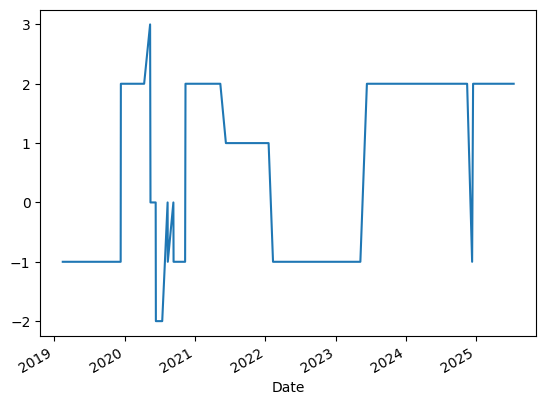

In [169]:
df['Regime'].plot()

In [170]:
import yfinance as yf

In [275]:

tkrs = ['USO', 'SPY', 'TLT', 'GLD','^VIX',"SPHY",'XLF', 'XLY', 'XLI', 'XLB', 'XLI', 'XLP', 'XLV', 'XBI']
prices = yf.download(tkrs, start='2010-01-01')[['Close']]
prices = prices.ffill().dropna()
prices.columns = prices.columns.get_level_values(1).unique()
corrdata = prices[['XLY', 'XLI', 'XLB', 'XLI', 'XLP', 'XLV', 'XBI']].pct_change().fillna(0)#.rolling(40).apply(get_x_asset_corr))
corrdata = corrdata.rolling(10).corr()
prices['cross_asset_corr'] = corrdata.groupby(corrdata.index.get_level_values(0)).mean().mean(axis =1)-1/(corrdata.shape[1])#.mean().plot()
#prices = prices.reindex(index =pd.date_range(start='2010-01-01',end= datetime.datetime.now().strftime('%Y-%m-%d'))).shift()
#prices.ffill( inplace=True)
#prices =prices.reindex(df.index)
prices[['GLD',"USO","SPHY","TLT","^VIX","SPY"]] = prices[['GLD',"USO","SPHY","TLT","^VIX","SPY"]].pct_change().fillna(0)
prices = prices[['GLD',"USO","SPHY","TLT","^VIX",'cross_asset_corr',"SPY"]]
prices['credit_spr'] = prices['TLT'] - prices['SPHY']
prices = prices[['GLD',"USO","TLT","^VIX",'cross_asset_corr',"SPY",'credit_spr']].shift().dropna()

[*********************100%***********************]  13 of 13 completed


regimes = [0]
for i in range(1,len(prices)):
    try:
        model = GaussianMixture(n_components=4, random_state=42)
        model.fit(prices.iloc[:i])
        label = model.predict(prices.iloc[[i]])
    except:
        label = [np.nan]
    regimes.append(label[0])
    #print(label)

In [276]:
model = GaussianMixture(n_components=4, random_state=42)
model = KMeans(n_clusters =3, random_state=42)
model.fit(prices.iloc[:2000])
labels = model.predict(prices)
prices['regime'] = labels

In [277]:
regime_vis = prices[['SPY','regime']]

In [278]:
regime_vis['SPY'] = (1+regime_vis['SPY']).cumprod()-1

C:\Users\kmavy\AppData\Local\Temp\ipykernel_27148\4207767365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regime_vis['SPY'] = (1+regime_vis['SPY']).cumprod()-1


C:\Users\kmavy\AppData\Local\Temp\ipykernel_27148\1671232744.py:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(data = regime_vis,x = regime_vis.index,y = regime_vis['SPY'],hue = 'regime',palette = colors,s = 10)\


Text(0.5, 1.0, 'SPY Returns Clustered by Regime')

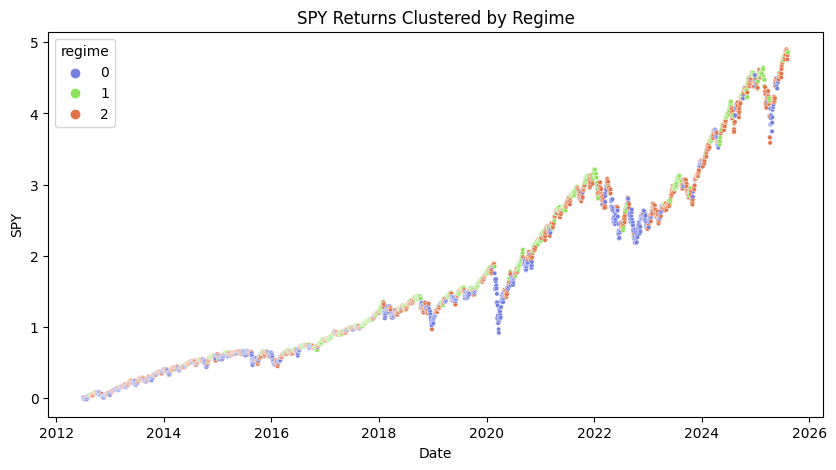

In [279]:
import seaborn as sns
plt.figure(figsize=(10, 5))
colors = ['#747FE3', '#8EE35D', '#E37346','goldenrod']
sns.scatterplot(data = regime_vis,x = regime_vis.index,y = regime_vis['SPY'],hue = 'regime',palette = colors,s = 10)\
.set_title('SPY Returns Clustered by Regime')

In [269]:
regime_vis.tail(60)

Ticker,SPY,regime
Date,,
2025-05-14,4.420949,2
2025-05-15,4.427878,2
2025-05-16,4.454389,2
2025-05-19,4.488937,2
2025-05-20,4.494941,2
2025-05-21,4.476467,2
2025-05-22,4.384184,2
2025-05-23,4.386309,2
2025-05-27,4.349543,2


In [203]:
# pip install scikit-learn numpy pandas
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [200]:
for i in range(2,7):
    model = GaussianMixture(n_components=i, random_state=42)
    model.fit(prices)
    labels = model.predict(prices)
    score = silhouette_score(prices, labels)
    print(i, score)

2 0.14361687277036997
3 0.11571375060505047
4 0.18914682107670913
5 -0.04826379985553877
6 0.014316637378098023
